# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#Load Data

train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size = 50 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here

model_al1 = Sequential()

model_al1.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

model_al1.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_al1.add(BatchNormalization())
model_al1.add(Activation('relu'))

model_al1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_al1.add(Flatten())

model_al1.add(Dense(1000, activation='relu'))
model_al1.add(Dropout(0.5))

model_al1.add(Dense(500, activation='relu'))
model_al1.add(Dropout(0.5))

#softmax layer
model_al1.add(Dense(5, activation='softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_al1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_al1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model_al1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 50
Source path =  train ; batch size = 50
Epoch 1/50
14/14 [==============================] - 216s 15s/step - loss: 3.5587 - categorical_accuracy: 0.2729 - val_loss: 5.7684 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-03-0215_54_36.441155/model-00001-3.59057-0.27903-5.76838-0.23000.h5
Epoch 2/50
14/14 [==============================] - 21s 2s/step - loss: 1.9403 - categorical_accuracy: 0.3187 - val_loss: 1.9832 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-03-0215_54_36.441155/model-00002-1.94034-0.31868-1.98320-0.31000.h5
Epoch 3/50
14/14 [==============================] - 23s 2s/step - loss: 1.4956 - categorical_accuracy: 0.4396 - val_loss: 1.2857 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-03-0215_54_36.441155/model-00003-1.49559-0.43956-1.28566-0.46000.h5
Epoch 4/50
14/14 [==============================] - 25s 2s/step - loss: 1.2975 - categor

14/14 [==============================] - 24s 2s/step - loss: 0.6055 - categorical_accuracy: 0.7143 - val_loss: 0.7194 - val_categorical_accuracy: 0.7600

Epoch 00028: saving model to model_init_2020-03-0215_54_36.441155/model-00028-0.60546-0.71429-0.71943-0.76000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 29/50
14/14 [==============================] - 23s 2s/step - loss: 0.6005 - categorical_accuracy: 0.7527 - val_loss: 0.6839 - val_categorical_accuracy: 0.7800

Epoch 00029: saving model to model_init_2020-03-0215_54_36.441155/model-00029-0.60054-0.75275-0.68389-0.78000.h5
Epoch 30/50
14/14 [==============================] - 23s 2s/step - loss: 0.5732 - categorical_accuracy: 0.7637 - val_loss: 0.6607 - val_categorical_accuracy: 0.8000

Epoch 00030: saving model to model_init_2020-03-0215_54_36.441155/model-00030-0.57321-0.76374-0.66069-0.80000.h5
Epoch 31/50
14/14 [==============================] - 23s 2s/step - loss: 0.5330 - categorical

In [13]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

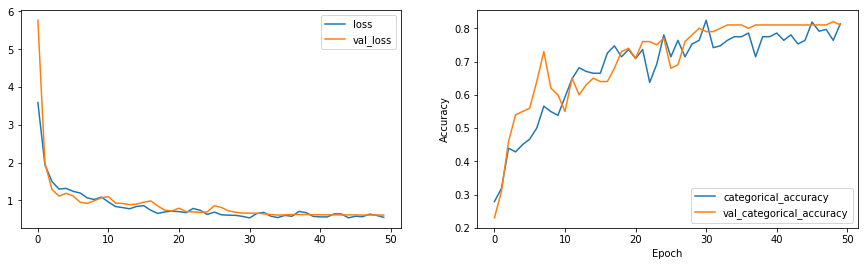

In [14]:
plot(history)

### Model 2: 2D Conv + RNN (Transfer Learning using MobileNet)

In [15]:
batch_size = 10
num_epochs = 25
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [16]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

17227776/17225924 [==============================] - 2s 0us/step


In [17]:
model_6 = Sequential()
model_6.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(128))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(5, activation='softmax'))

In [18]:
train_generator6 = generator(train_path, train_doc, batch_size)
val_generator6 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
history6 = model_6.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 10
Source path =  train ; batch size = 10
Epoch 1/25
67/67 [==============================] - 91s 1s/step - loss: 1.6612 - categorical_accuracy: 0.2303 - val_loss: 1.3931 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-03-0215_54_36.441155/model-00001-1.66149-0.22926-1.39315-0.44000.h5
Epoch 2/25
67/67 [==============================] - 28s 425ms/step - loss: 1.4510 - categorical_accuracy: 0.3582 - val_loss: 1.2861 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-03-0215_54_36.441155/model-00002-1.45095-0.35821-1.28610-0.54000.h5
Epoch 3/25
67/67 [==============================] - 29s 430ms/step - loss: 1.3821 - categorical_accuracy: 0.3930 - val_loss: 1.2199 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-03-0215_54_36.441155/model-00003-1.38213-0.39303-1.21992-0.58000.h5
Epoch 4/25
67/67 [==============================] - 29s 426ms/step - loss: 1.3379 - 

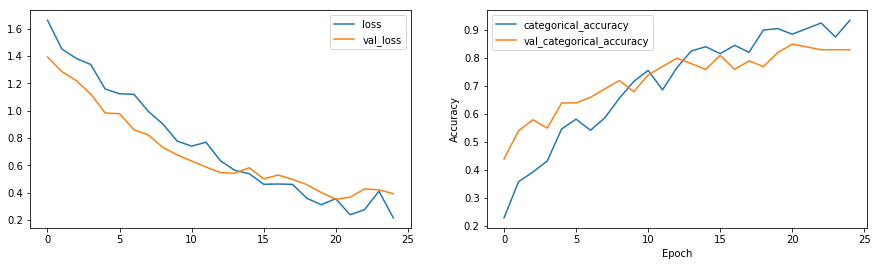

In [22]:
plot(history6)